# Correlations between Cross-sectional and pregnant women 

This notebook aims to quantify the correlation between the prevalences in data from cross-sectional and pregnant women  

In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
%matplotlib inline
from matplotlib import cm
import scipy.stats as sci_stats
import scipy.optimize as optimization
from stat_tools.errors import chi_square, bootstrap_resample
from stat_tools.stats import pearson_cc_boostrap
from stat_tools import tables
from pregmal_pytools import notebook_pytools, temporal_utils
from time import time

In [2]:
def linfit_pcc(cross210, mipmon, mipmon_areas, cross_areas, cross_test_type, mip_test_type, cross_bins, \
                           time_width, time_shift, print_sizes = True, \
                           cross_mask = None, mip_mask = None, title = '', \
                           verbose = True, rounding = 3, get_chi2 = False):
    """
    This method outputs the linear fit parameters and the Pearson CC comparing the positivity rates between 
    cross-sectional and ANC data. 
    
    Parameters: 
    -----------
    cross210: pd.DataFrame
        Data and metadata from cross-sectional surveys.
    mipmon: : pd.DataFrame
        Data and metadata from pregnant women at ANC.
    cross_areas: list
        List of areas to be used for the stratification of cross-sectional data. 
    cross_test_type: str
        Name of the test result used for cross-sectional data. 
    mip_test_type: str
        Name of the test result used in ANC data. 
    cross_bins: int or list
        Number of cross-sectional bins, or list of dates from which to split. 
    time_width: float
        Temporal window size for the selection of pregnant women around the dates
        of the cross-sectionals. 
    time_shift: float
        Temporal shift to apply for the temporal window. 
    print_sizes: bool
        If True, sample sizes are printed out. 
    cross_mask: np.array
        Boolean array to mask a selection of samples from cross-sectional data. 
    mip_mask: np.array
        Boolean array to mask a selection of samples from ANC data. 
    title: str
        Title to show in plots.
    verbose: bool
        If True, some extra text is printed out. 
    rounding: int
        Level of rounding of printed results.
    get_chi2: bool
        If True, chi2 statistics is obtained. 
        
    Returns:
    --------
    p_all: float
        Linear regression coefficients of all data.
    fit_err: float
        Standard deviation error of linear regression coefficients from bootstrap resampling. 
    fit_mean: float
        Mean linear regression coefficients from bootstrap resampling. 
    origin_conf_95: [float, float]
        95CI of origin parameter
    origin_conf_68: [float, float]
        68CI of origin parameter
    slope_conf_95: [float, float]
        95CI of slope parameter
    slope_conf_68: [float, foat]
        68CI of slope parameter
    pcorr_all: float
        Pearson correlation coefficient
    pcorr_err: float
        Standard deviation error of Pearson CC from bootstrap resampling. 
    conf_95: [float, float]
        95CI of slope parameter of Pearson CC
    conf_68: [float, float]
        68CI of slope parameter of Pearson CC
    pcorr_mean: float
        Mean Pearson CC from bootstrap resamples.
    chi2: float
        Chi square of deviation between cross-sectional and ANC data. 
    """
    all_cross = np.array([])
    all_mip = np.array([])
    all_cross_err = np.array([])
    all_mip_err = np.array([])
    all_cross_r = []
    all_mip_r = []
    for i in range(len(mipmon_areas)):
        cross_dates, cross_mean, cross_err, cross_means = notebook_pytools.get_cross_prev_bins(cross210, cross_areas[i], \
                                                                                               cross_test_type, cross_bins, \
                                                                 print_sizes = print_sizes, cross_mask = cross_mask, \
                                                                 verbose = verbose, ret_resamples = True)
        #MiPMon
        if mip_mask is None:
            mipmon_mask = mipmon['visit'].notnull()
        else:
            mipmon_mask = mipmon['visit'].notnull()&mip_mask
        mipmon_dates, mipmon_mean, mipmon_err, mipmon_means = notebook_pytools.get_mipmon_prev_bins(mipmon, mipmon_areas[i], \
                                                                                                    mip_test_type, cross_dates, \
                                                                     time_width, time_shift, mask = mipmon_mask, \
                                                                     print_sizes = print_sizes, \
                                                                     verbose = verbose, ret_resamples = True)
        all_cross = np.concatenate((all_cross, cross_mean))
        all_cross_err = np.concatenate((all_cross_err, cross_err))
        all_cross_r.append(cross_means)
        all_mip = np.concatenate((all_mip, mipmon_mean))
        all_mip_err = np.concatenate((all_mip_err, mipmon_err))
        all_mip_r.append(mipmon_means)
    
    all_cross_r, all_mip_r = np.array(all_cross_r), np.array(all_mip_r)
    
    #Linear fits
    mask = (all_cross**2. >= 0)&(all_mip**2. >= 0)&(all_cross_err > 0)&(all_mip_err > 0)
    try:
        p_all = np.polyfit(all_cross[mask], all_mip[mask], 1)
    except:
        p_all = np.nan, np.nan
    #Pearson CC
    pcorr_all = sci_stats.pearsonr(all_cross[mask], all_mip[mask])[0]
    #chi2
    chi2 = chi_square(all_cross[mask], all_cross_err[mask], all_mip[mask], all_mip_err[mask])
    
    #Results from resamples
    fit_vals = []
    pcorrs = []
    nrands = all_cross_r.shape[-1]
    for i in range(nrands):
        mask = all_cross_r[:,:,i]**2. >= 0
        try:
            p_all_r = np.polyfit(all_cross_r[:,:,i][mask], all_mip_r[:,:,i][mask], 1)
        except:
            p_all_r = np.nan, np.nan
        fit_vals.append(p_all_r)
        pcorrs.append(sci_stats.pearsonr(all_cross_r[:,:,i][mask], all_mip_r[:,:,i][mask])[0])
    fit_vals, pcorrs = np.array(fit_vals), np.array(pcorrs)
    #Printing results
    if verbose:
        print("Cross vs MiPMon " + title + ':')
        print("Linear parameter fitting: origin = " + str(p_all[1]) + ", slope = " + str(p_all[0]))
        print("Pearson CC: ", pcorr_all)
        print()
        
    vals_mask = np.invert(np.isnan(fit_vals[:,0]))
    fit_err = np.std(fit_vals[vals_mask], axis = 0)
    pcorr_err = np.std(pcorrs)
    sorted_origin = np.sort(fit_vals[:,1])
    sorted_slope = np.sort(fit_vals[:,0])
    origin_conf_95 = [sorted_origin[int(nrands*.025)], sorted_origin[int(nrands*.975)]]
    origin_conf_68 = [sorted_origin[int(nrands*.16)], sorted_origin[int(nrands*.84)]]
    slope_conf_95 = [sorted_slope[int(nrands*.025)], sorted_slope[int(nrands*.975)]]
    slope_conf_68 = [sorted_slope[int(nrands*.16)], sorted_slope[int(nrands*.84)]]
    sorted_pcorrs = np.sort(pcorrs)
    conf_95 = [sorted_pcorrs[int(nrands*.025)], sorted_pcorrs[int(nrands*.975)]]
    conf_68 = [sorted_pcorrs[int(nrands*.16)], sorted_pcorrs[int(nrands*.84)]]
    fit_mean = np.mean(fit_vals[vals_mask], axis = 0)
    pcorr_mean = np.mean(pcorrs)
    #return p_all, pcorr_all
    
    p_all, fit_err = np.round(p_all, rounding), np.round(fit_err, rounding)
    origin_conf_95, origin_conf_68 = np.round(origin_conf_95,rounding), np.round(origin_conf_68,rounding)
    slope_conf_95, slope_conf_68 = np.round(slope_conf_95,rounding), np.round(slope_conf_68,rounding)
    fit_mean, pcorr_all = np.round(fit_mean, rounding), np.round(pcorr_all, rounding)
    pcorr_err, conf_95 = np.round(pcorr_err, rounding), np.round(conf_95, rounding)
    conf_68, pcorr_mean = np.round(conf_68, rounding), np.round(pcorr_mean, rounding)
    if get_chi2:
        return p_all, fit_err, fit_mean, origin_conf_95, origin_conf_68, slope_conf_95, \
                slope_conf_68, pcorr_all, pcorr_err, conf_95, conf_68, pcorr_mean, chi2
    else:
        return p_all, fit_err, fit_mean, origin_conf_95, origin_conf_68, slope_conf_95, \
                slope_conf_68, pcorr_all, pcorr_err, conf_95, conf_68, pcorr_mean




# Import data 

In [3]:
#Defining data paths
data_path = 'data/'
cross_filename = data_path + 'cross_merged.csv'
mipmon_filename = data_path + 'mipmon_merged.csv' 

#Loading and preprocessing data
cross = pd.read_csv(cross_filename)
#Filter Cross to only 2-10
cross210 = cross[(cross['age']>=2)&(cross['age']<=10)]
mipmon = pd.read_csv(mipmon_filename)
#Reformating dates
cross['visdate'] = pd.to_datetime(cross['visdate'])
cross210['visdate'] = pd.to_datetime(cross210['visdate'])
mipmon['visdate'] = pd.to_datetime(mipmon['visdate'])
#Quantify tests
cross['pospcr'][cross['pospcr'] == 'Negative'] = 0.
cross['pospcr'][cross['pospcr'] == 'Positive'] = 1.
cross['rdt'][cross['rdt'] == 'Negative'] = 0.
cross['rdt'][cross['rdt'] == 'Positive'] = 1.
cross210['pospcr'][cross210['pospcr'] == 'Negative'] = 0.
cross210['pospcr'][cross210['pospcr'] == 'Positive'] = 1.
cross210['rdt'][cross210['rdt'] == 'Negative'] = 0.
cross210['rdt'][cross210['rdt'] == 'Positive'] = 1.
mipmon['pcrpos'][mipmon['pcrpos'] == 'PCR-'] = 0
mipmon['pcrpos'][mipmon['pcrpos'] == 'PCR+'] = 1
#Fixing one crazy value
cross['lat'][cross['lat']>0] = -cross['lat'][cross['lat']>0]

/tmp/ipykernel_213770/1535411327.py:13: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  cross210['visdate'] = pd.to_datetime(cross210['visdate'])
/tmp/ipykernel_213770/1535411327.py:16: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  cross['pospcr'][cross['pospcr'] == 'Negative'] = 0.
/tmp/ipykernel_213770/1535411327.py:17: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  cross['pospcr'

### Define parameters 

In [4]:
#Regions to compare
mipmon_areas = [['Magude-sede'], ['Ilha-Josina'], ['Manhica-Sede']]#, ['Pandjane'], ['3 de Fevereiro']]
cross_areas = [['Magude Sede'], ['Ilha Josina'], ['Manhiça']]#, ['Panjane'], ['Taninga', 'Palmeira', 'Malavele']]

cross_bins = ['2017', '2018', '2019', '2020']

In [5]:
colors = [cm.turbo((i+1)/float(len(mipmon_areas) + 1)) for i in range(len(mipmon_areas) + 1)]

### Define masks 

In [6]:
#Define mask for cross-sectional PCRs due to sampling issues
cross_pcr_mask = cross210['pospcr'].notnull()
cross_pcr_mask[(cross210['visdate'] < '2018')&(cross210['area'] == 'Manhiça')] = False
#cross_pcr_mask[(cross210['visdate'] > '2018')&(cross210['visdate'] < '2019')&(cross210['area'] == 'Magude Sede')] = False

#Define masks for MiPMon data
mipmon_pn = mipmon['visit'] == 'PN'
mipmon_pg = mipmon_pn&(mipmon['gestnum'] == 1)
mipmon_mg = mipmon_pn&(mipmon['gestnum'] > 1)
mipmon_hiv_pos = mipmon_pn&(mipmon['hiv'] == 'HIV+')
mipmon_hiv_neg = mipmon_pn&(mipmon['hiv'] == 'HIV-')
mipmon_pg_hiv_pos = mipmon_pg&mipmon_hiv_pos
mipmon_pg_hiv_neg = mipmon_pg&mipmon_hiv_neg

mipmon_selection = {
    'ANC (all)' : mipmon_pn,
    'ANC (PG)' : mipmon_pg,
    'ANC (MG)' : mipmon_mg,
    'ANC (HIV+)' : mipmon_hiv_pos,
    'ANC (HIV-)' : mipmon_hiv_neg,
    #'PG HIV+' : mipmon_pg_hiv_pos,
    'ANC (PG HIV-)' : mipmon_pg_hiv_neg,
}

# Figures for paper 

In [7]:
#Regions to compare
mipmon_areas = [['Magude-sede'], ['Ilha-Josina'], ['Manhica-Sede']]#, ['Pandjane'], ['3 de Fevereiro']]
cross_areas = [['Magude Sede'], ['Ilha Josina'], ['Manhiça']]#, ['Panjane'], ['Taninga', 'Palmeira', 'Malavele']]

cross_bins = ['2017', '2018', '2019', '2020']

In [8]:
mipmon_selection = {
    'ANC (all)' : mipmon_pn,
    'ANC (PG)' : mipmon_pg,
    #'Secundigravid' : mipmon_sg,
    #'1-2gravid' : mipmon_12g,
    #'>2gravid' : mipmon_3g,
    'ANC (MG)' : mipmon_mg,
    'ANC (HIV+)' : mipmon_hiv_pos,
    'ANC (HIV-)' : mipmon_hiv_neg,
    #'PG HIV+' : mipmon_pg_hiv_pos,
    'ANC (PG HIV-)' : mipmon_pg_hiv_neg,
}

Cross vs MiPMon ANC (all):
Linear parameter fitting: origin = 0.026204631237728107, slope = 0.9896804886179338
Pearson CC:  0.9590983022005855



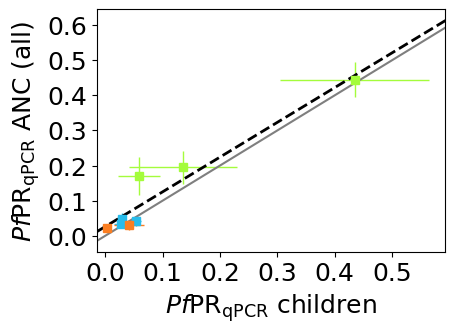

Cross vs MiPMon ANC (PG):
Linear parameter fitting: origin = 0.038799246199462394, slope = 1.1521084704829299
Pearson CC:  0.9397317260936074



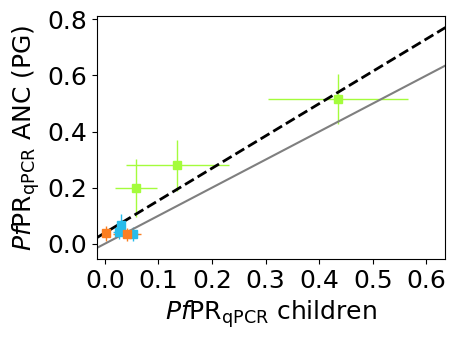

Cross vs MiPMon ANC (MG):
Linear parameter fitting: origin = 0.020804187284524156, slope = 0.9112879807954419
Pearson CC:  0.9635659067079393



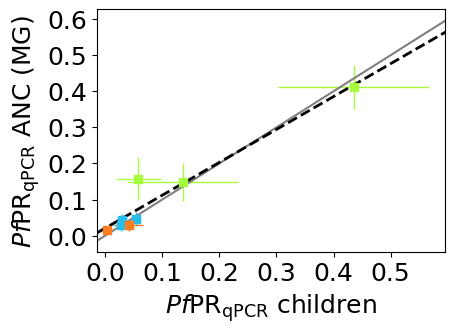

Cross vs MiPMon ANC (HIV+):
Linear parameter fitting: origin = 0.0032023056089258736, slope = 1.1428113294377946
Pearson CC:  0.9977978991666571



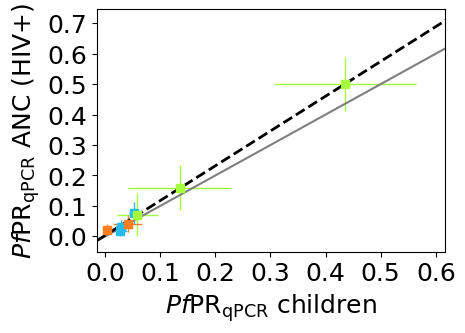

Cross vs MiPMon ANC (HIV-):
Linear parameter fitting: origin = 0.035112775706295805, slope = 0.9266849125340495
Pearson CC:  0.9158711928237356



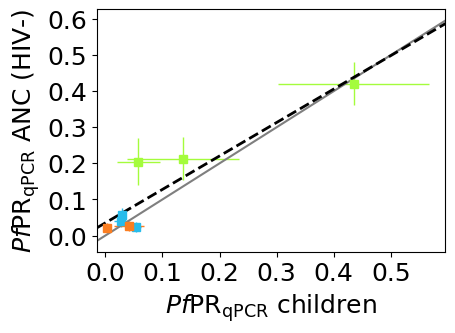

Cross vs MiPMon ANC (PG HIV-):
Linear parameter fitting: origin = 0.04656335513798367, slope = 1.0733657354949093
Pearson CC:  0.8891769072773452



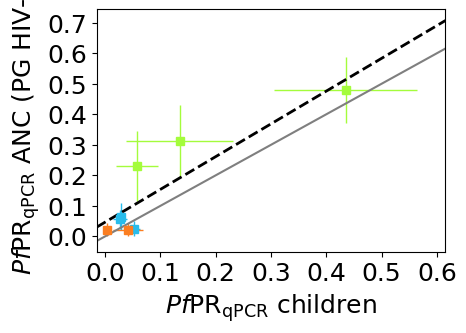

Time taken  20.49891686439514  seconds ( 0 minutes)


In [9]:
#Define test and time binning comparison
cross_test_type = 'pcr'
mip_test_type = 'pcr'
cross_mask = cross_pcr_mask
time_width = 90
time_shift = 0

fit_params = [{},{}]
fit_errs = [{},{}]
slope_95 = {}
slope_68 = {}
origin_95 = {}
origin_68 = {}
pearsonCCs = {}
pearsonCC_errs = {}
pearsonCC_95 = {}
pearsonCC_68 = {}

start = time()
for i in mipmon_selection:
    #Plotting scatter
    p, pcorr = notebook_pytools.scatter_linfit_pcc(cross210, mipmon, mipmon_areas, cross_areas, \
                                    cross_test_type, mip_test_type, cross_bins, \
                    time_width = time_width, time_shift = time_shift, print_sizes = False, \
                       cross_mask = cross_mask, mip_mask = mipmon_selection[i], \
                                        title = i, verbose = False, legend = False, fontsize = 18, \
                                                  frameon = True, framealpha = 1)
    #Calculating statistics
    p_all, fit_err, fit_mean, origin_95[i], origin_68[i], slope_95[i], slope_68[i], \
    pearsonCCs[i], pearsonCC_errs[i], pearsonCC_95[i], pearsonCC_68[i], pcorr_mean = linfit_pcc(cross210, \
                                                        mipmon, mipmon_areas, cross_areas, \
                                                        cross_test_type, mip_test_type, cross_bins, \
                                            time_width = time_width, time_shift = time_shift, print_sizes = False, \
                                               cross_mask = cross_mask, mip_mask = mipmon_selection[i], \
                                                        title = i, verbose = False)
    fit_params[0][i], fit_params[1][i] = p_all
    fit_errs[0][i], fit_errs[1][i] = fit_err

end = time()
print('Time taken ', end-start,' seconds (', int((end-start)/60), 'minutes)')

In [10]:
pcr_results = pd.DataFrame({'slope': fit_params[0], \
              'slope error': fit_errs[0], \
              'slope 95CI': slope_95, \
              'slope 68CI': slope_68, \
              'origin': fit_params[1], \
              'origin error': fit_errs[1], \
              'origin 95CI': origin_95, \
              'origin 68CI': origin_68, \
              'PCC' : pearsonCCs, \
              'PCC error' : pearsonCC_errs, \
              'PCC 95CI' : pearsonCC_95,\
              'PCC 68CI' : pearsonCC_68})


In [11]:
pcr_results

,slope,slope error,slope 95CI,slope 68CI,origin,origin error,origin 95CI,origin 68CI,PCC,PCC error,PCC 95CI,PCC 68CI
ANC (all),0.990,0.438,"[0.547, 2.133]","[0.682, 1.369]",0.026,0.022,"[-0.021, 0.066]","[0.01, 0.05]",0.959,0.076,"[0.721, 0.986]","[0.835, 0.964]"
ANC (PG),1.152,0.476,"[0.519, 2.402]","[0.767, 1.551]",0.039,0.032,"[-0.024, 0.104]","[0.012, 0.075]",0.940,0.113,"[0.589, 0.981]","[0.756, 0.953]"
ANC (MG),0.911,0.403,"[0.458, 1.942]","[0.618, 1.228]",0.021,0.021,"[-0.021, 0.064]","[0.004, 0.044]",0.964,0.110,"[0.64, 0.991]","[0.822, 0.971]"
ANC (HIV+),1.143,0.486,"[0.531, 2.316]","[0.744, 1.519]",0.003,0.027,"[-0.043, 0.06]","[-0.015, 0.037]",0.998,0.107,"[0.644, 0.992]","[0.856, 0.978]"
ANC (HIV-),0.927,0.397,"[0.443, 2.025]","[0.627, 1.26]",0.035,0.023,"[-0.011, 0.081]","[0.016, 0.063]",0.916,0.103,"[0.63, 0.976]","[0.754, 0.941]"
ANC (PG HIV-),1.073,0.553,"[0.411, 2.495]","[0.657, 1.531]",0.047,0.037,"[-0.022, 0.121]","[0.013, 0.087]",0.889,0.153,"[0.395, 0.972]","[0.637, 0.929]"


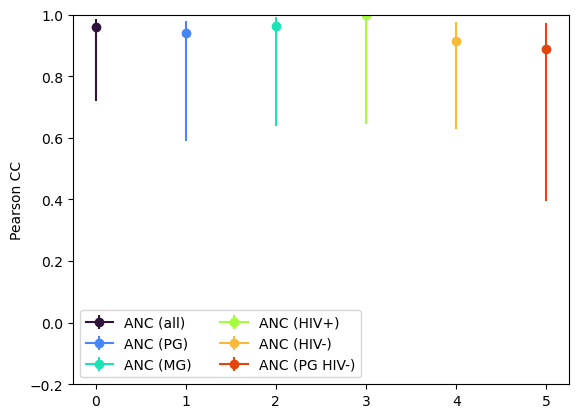

In [13]:
colors_s = [cm.turbo(i/len(mipmon_selection)) for i in range(len(mipmon_selection))]

for s, selection in enumerate(mipmon_selection):
    x = s
    y = pcr_results['PCC'][selection]
    yerr_bot = max(pcr_results['PCC'][selection] - pcr_results['PCC 95CI'][selection][0], 0)
    yerr_top = max(pcr_results['PCC 95CI'][selection][1] - pcr_results['PCC'][selection], 0)
    plt.errorbar(x, y, [[yerr_bot], [yerr_top]], marker = 'o', label = selection, color = colors_s[s])
#plt.xticks(ticks = np.arange(len(mipmon_selection)), labels = list(mipmon_selection.keys()))
plt.legend(ncol = 2)
plt.ylabel('Pearson CC')
plt.ylim(-.2,1)
plt.show()

Cross vs MiPMon ANC (all):
Linear parameter fitting: origin = 0.0191393880664682, slope = 0.3218074639546419
Pearson CC:  0.8694471763362752



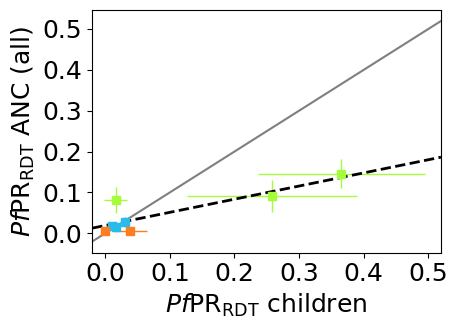

Cross vs MiPMon ANC (PG):
Linear parameter fitting: origin = 0.031447497765129166, slope = 0.6887737565573779
Pearson CC:  0.7246014787871116



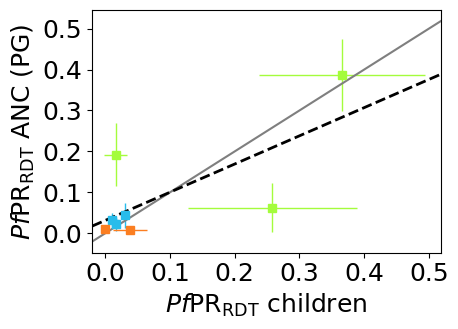

Cross vs MiPMon ANC (MG):
Linear parameter fitting: origin = 0.011641126959371957, slope = 0.17028197626014419
Pearson CC:  0.7216491048507394



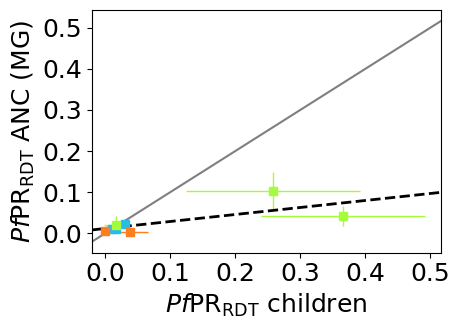

Cross vs MiPMon ANC (HIV+):
Linear parameter fitting: origin = 0.003683124716316664, slope = 0.426848579883975
Pearson CC:  0.9158399393394497



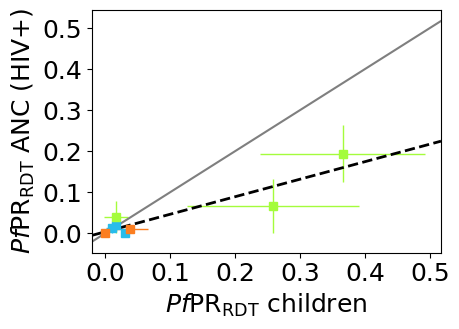

Cross vs MiPMon ANC (HIV-):
Linear parameter fitting: origin = 0.026388539223455534, slope = 0.273091652332479
Pearson CC:  0.7613948780229693



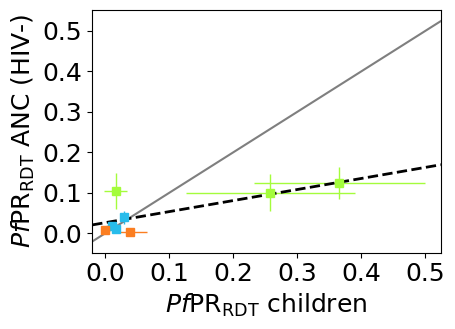

Cross vs MiPMon ANC (PG HIV-):
Linear parameter fitting: origin = 0.04497258794753384, slope = 0.5920862517932902
Pearson CC:  0.6590422571031427



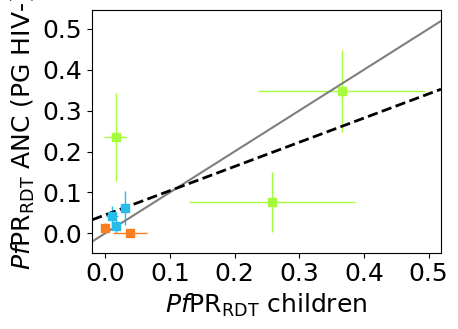

Time taken  18.809834241867065  seconds ( 0 minutes)


In [14]:
#Define test and time binning comparison
cross_test_type = 'rdt'
mip_test_type = 'rdt'
cross_mask = cross_pcr_mask
time_width = 90
time_shift = 0

fit_params = [{},{}]
fit_errs = [{},{}]
slope_95 = {}
slope_68 = {}
origin_95 = {}
origin_68 = {}
pearsonCCs = {}
pearsonCC_errs = {}
pearsonCC_95 = {}
pearsonCC_68 = {}

start = time()
for i in mipmon_selection:
    #Plotting scatter
    p, pcorr = notebook_pytools.scatter_linfit_pcc(cross210, mipmon, mipmon_areas, cross_areas, \
                                    cross_test_type, mip_test_type, cross_bins, \
                    time_width = time_width, time_shift = time_shift, print_sizes = False, \
                       cross_mask = cross_mask, mip_mask = mipmon_selection[i], \
                                        title = i, verbose = False, legend = False, fontsize = 18)
    #Calculating statistics
    p_all, fit_err, fit_mean, origin_95[i], origin_68[i], slope_95[i], slope_68[i], \
    pearsonCCs[i], pearsonCC_errs[i], pearsonCC_95[i], pearsonCC_68[i], pcorr_mean = linfit_pcc(cross210, \
                                                        mipmon, mipmon_areas, cross_areas, \
                                                        cross_test_type, mip_test_type, cross_bins, \
                                            time_width = time_width, time_shift = time_shift, print_sizes = False, \
                                               cross_mask = cross_mask, mip_mask = mipmon_selection[i], \
                                                        title = i, verbose = False)
    fit_params[0][i], fit_params[1][i] = p_all
    fit_errs[0][i], fit_errs[1][i] = fit_err
end = time()
print('Time taken ', end-start,' seconds (', int((end-start)/60), 'minutes)')

In [15]:
rdt_results = pd.DataFrame({'slope': fit_params[0], \
              'slope error': fit_errs[0], \
              'slope 95CI': slope_95, \
              'slope 68CI': slope_68, \
              'origin': fit_params[1], \
              'origin error': fit_errs[1], \
              'origin 95CI': origin_95, \
              'origin 68CI': origin_68, \
              'PCC' : pearsonCCs, \
              'PCC error' : pearsonCC_errs, \
              'PCC 95CI' : pearsonCC_95,\
              'PCC 68CI' : pearsonCC_68})


In [16]:
rdt_results

,slope,slope error,slope 95CI,slope 68CI,origin,origin error,origin 95CI,origin 68CI,PCC,PCC error,PCC 95CI,PCC 68CI
ANC (all),0.311,0.159,"[0.1, 0.694]","[0.189, 0.432]",0.022,0.008,"[0.006, 0.039]","[0.014, 0.03]",0.859,0.166,"[0.336, 0.966]","[0.602, 0.913]"
ANC (PG),0.671,0.408,"[0.057, 1.669]","[0.355, 0.992]",0.036,0.023,"[-0.002, 0.089]","[0.015, 0.06]",0.704,0.229,"[0.067, 0.954]","[0.427, 0.871]"
ANC (MG),0.164,0.124,"[-0.01, 0.451]","[0.052, 0.272]",0.013,0.008,"[-0.0, 0.031]","[0.006, 0.021]",0.699,0.285,"[-0.046, 0.966]","[0.288, 0.888]"
ANC (HIV+),0.411,0.232,"[0.06, 1.002]","[0.21, 0.605]",0.009,0.012,"[-0.012, 0.035]","[-0.003, 0.019]",0.907,0.219,"[0.177, 0.985]","[0.566, 0.954]"
ANC (HIV-),0.258,0.149,"[0.05, 0.637]","[0.146, 0.403]",0.031,0.010,"[0.01, 0.049]","[0.019, 0.039]",0.740,0.213,"[0.16, 0.947]","[0.422, 0.854]"
ANC (PG HIV-),0.518,0.397,"[0.046, 1.422]","[0.267, 0.901]",0.070,0.025,"[0.004, 0.1]","[0.024, 0.076]",0.612,0.240,"[0.05, 0.938]","[0.331, 0.829]"


In [17]:
fontsize = 18

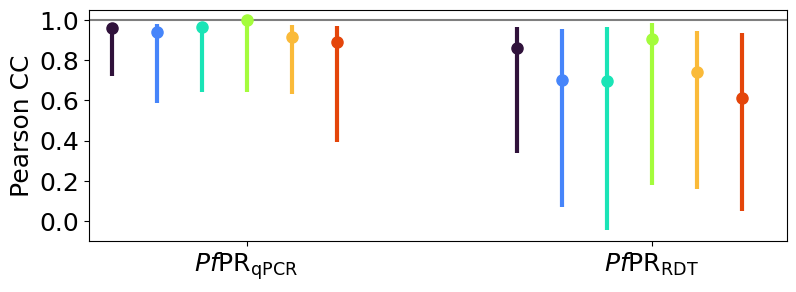

In [18]:
colors_s = [cm.turbo(i/len(mipmon_selection)) for i in range(len(mipmon_selection))]

plt.figure(figsize=[9,3])
for s, selection in enumerate(mipmon_selection):
    x = s
    y = pcr_results['PCC'][selection]
    yerr_bot = max(pcr_results['PCC'][selection] - pcr_results['PCC 95CI'][selection][0], 0)
    yerr_top = max(pcr_results['PCC 95CI'][selection][1] - pcr_results['PCC'][selection], 0)
    plt.errorbar(x, y, [[yerr_bot], [yerr_top]], marker = 'o', markersize = 8, label = selection, color = colors_s[s], lw = 3)
for s, selection in enumerate(mipmon_selection):
    x = 1.5*len(mipmon_selection) + s
    y = rdt_results['PCC'][selection]
    yerr_bot = max(rdt_results['PCC'][selection] - rdt_results['PCC 95CI'][selection][0], 0)
    yerr_top = max(rdt_results['PCC 95CI'][selection][1] - rdt_results['PCC'][selection], 0)
    plt.errorbar(x, y, [[yerr_bot], [yerr_top]], marker = 'o', markersize = 8, label = None, color = colors_s[s], lw = 3)
plt.xticks(ticks = [.5*len(mipmon_selection), 2.*len(mipmon_selection)], \
           labels = [r'$Pf\rm{PR}_{\rm{qPCR}}$', r'$Pf\rm{PR}_{\rm{RDT}}$'], fontsize = fontsize)
plt.yticks(fontsize = fontsize)
#plt.legend(ncol = 6, framealpha = 1, fontsize = fontsize)
plt.ylabel('Pearson CC', fontsize = fontsize)
plt.hlines(1, -.5, 2.5*len(mipmon_selection), color = 'tab:grey')
plt.xlim(-.5, 2.5*len(mipmon_selection))
plt.show()

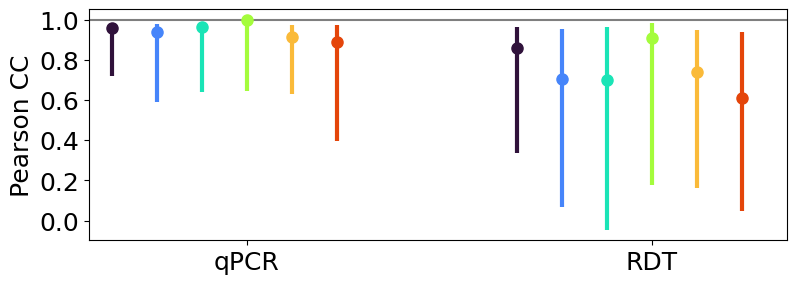

In [19]:
colors_s = [cm.turbo(i/len(mipmon_selection)) for i in range(len(mipmon_selection))]

plt.figure(figsize=[9,3])
for s, selection in enumerate(mipmon_selection):
    x = s
    y = pcr_results['PCC'][selection]
    yerr_bot = max(pcr_results['PCC'][selection] - pcr_results['PCC 95CI'][selection][0], 0)
    yerr_top = max(pcr_results['PCC 95CI'][selection][1] - pcr_results['PCC'][selection], 0)
    plt.errorbar(x, y, [[yerr_bot], [yerr_top]], marker = 'o', markersize = 8, label = selection, color = colors_s[s], lw = 3)
for s, selection in enumerate(mipmon_selection):
    x = 1.5*len(mipmon_selection) + s
    y = rdt_results['PCC'][selection]
    yerr_bot = max(rdt_results['PCC'][selection] - rdt_results['PCC 95CI'][selection][0], 0)
    yerr_top = max(rdt_results['PCC 95CI'][selection][1] - rdt_results['PCC'][selection], 0)
    plt.errorbar(x, y, [[yerr_bot], [yerr_top]], marker = 'o', markersize = 8, label = None, color = colors_s[s], lw = 3)
plt.xticks(ticks = [.5*len(mipmon_selection), 2.*len(mipmon_selection)], \
           labels = ['qPCR', 'RDT'], fontsize = fontsize)
plt.yticks(fontsize = fontsize)
#plt.legend(ncol = 6, framealpha = 1, fontsize = fontsize)
plt.ylabel('Pearson CC', fontsize = fontsize)
plt.hlines(1, -.5, 2.5*len(mipmon_selection), color = 'tab:grey')
plt.xlim(-.5, 2.5*len(mipmon_selection))
plt.show()

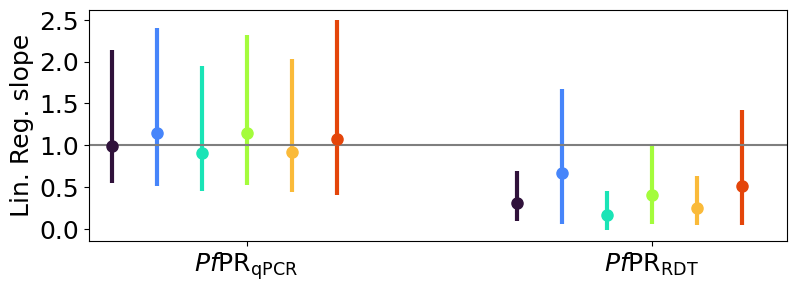

In [20]:
colors_s = [cm.turbo(i/len(mipmon_selection)) for i in range(len(mipmon_selection))]

plt.figure(figsize=[9,3])
for s, selection in enumerate(mipmon_selection):
    x = s
    y = pcr_results['slope'][selection]
    yerr_bot = max(pcr_results['slope'][selection] - pcr_results['slope 95CI'][selection][0], 0)
    yerr_top = max(pcr_results['slope 95CI'][selection][1] - pcr_results['slope'][selection], 0)
    plt.errorbar(x, y, [[yerr_bot], [yerr_top]], marker = 'o', markersize = 8, label = selection, color = colors_s[s], lw = 3)
for s, selection in enumerate(mipmon_selection):
    x = 1.5*len(mipmon_selection) + s
    y = rdt_results['slope'][selection]
    yerr_bot = max(rdt_results['slope'][selection] - rdt_results['slope 95CI'][selection][0], 0)
    yerr_top = max(rdt_results['slope 95CI'][selection][1] - rdt_results['slope'][selection], 0)
    plt.errorbar(x, y, [[yerr_bot], [yerr_top]], marker = 'o', markersize = 8, label = None, color = colors_s[s], lw = 3)
plt.xticks(ticks = [.5*len(mipmon_selection), 2.*len(mipmon_selection)], \
           labels = [r'$Pf\rm{PR}_{\rm{qPCR}}$', r'$Pf\rm{PR}_{\rm{RDT}}$'], fontsize = fontsize)
plt.yticks(fontsize = fontsize)
#plt.legend(ncol = 2)
plt.ylabel('Lin. Reg. slope', fontsize = fontsize)
plt.hlines(1, -.5, 2.5*len(mipmon_selection), color = 'tab:grey')
plt.xlim(-.5, 2.5*len(mipmon_selection))
plt.show()

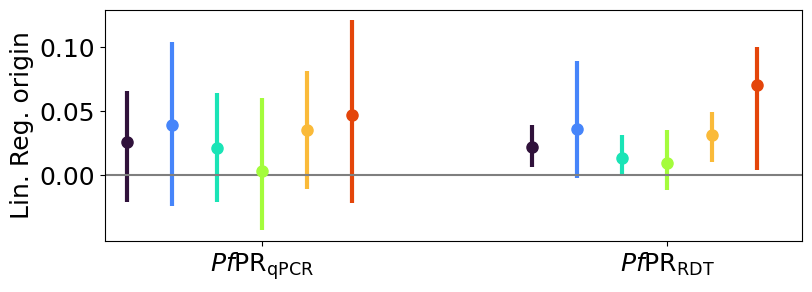

In [21]:
colors_s = [cm.turbo(i/len(mipmon_selection)) for i in range(len(mipmon_selection))]

plt.figure(figsize=[9,3])
for s, selection in enumerate(mipmon_selection):
    x = s
    y = pcr_results['origin'][selection]
    yerr_bot = max(pcr_results['origin'][selection] - pcr_results['origin 95CI'][selection][0], 0)
    yerr_top = max(pcr_results['origin 95CI'][selection][1] - pcr_results['origin'][selection], 0)
    plt.errorbar(x, y, [[yerr_bot], [yerr_top]], marker = 'o', markersize = 8, label = selection, color = colors_s[s], lw = 3)
for s, selection in enumerate(mipmon_selection):
    x = 1.5*len(mipmon_selection) + s
    y = rdt_results['origin'][selection]
    yerr_bot = max(rdt_results['origin'][selection] - rdt_results['origin 95CI'][selection][0], 0)
    yerr_top = max(rdt_results['origin 95CI'][selection][1] - rdt_results['origin'][selection], 0)
    plt.errorbar(x, y, [[yerr_bot], [yerr_top]], marker = 'o', markersize = 8, label = None, color = colors_s[s], lw = 3)
plt.xticks(ticks = [.5*len(mipmon_selection), 2.*len(mipmon_selection)], \
           labels = [r'$Pf\rm{PR}_{\rm{qPCR}}$', r'$Pf\rm{PR}_{\rm{RDT}}$'], fontsize = fontsize)
plt.yticks(ticks = [0, .05, .1], fontsize = fontsize)
#plt.legend(ncol = 2)
plt.ylabel('Lin. Reg. origin', fontsize = fontsize)
plt.hlines(0, -.5, 2.5*len(mipmon_selection), color = 'tab:grey')
plt.xlim(-.5, 2.5*len(mipmon_selection))
plt.show()

### Splitting by transmission level 

#### Low transmission 

In [22]:
mipmon_areas = [['Magude-sede'], ['Manhica-Sede']]#, ['Pandjane'], ['3 de Fevereiro']]
cross_areas = [['Magude Sede'], ['Manhiça']]#, ['Panjane'], ['Taninga', 'Palmeira', 'Malavele']]


Cross vs MiPMon ANC (all):
Linear parameter fitting: origin = 0.025001261789503872, slope = 0.3276215273138026
Pearson CC:  0.5884965717177183



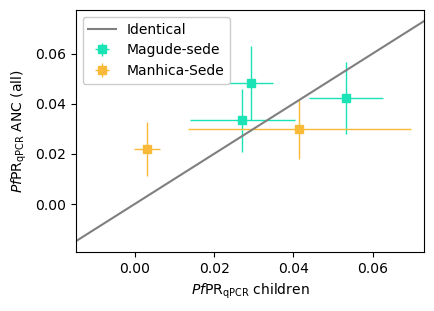

Cross vs MiPMon ANC (PG):
Linear parameter fitting: origin = 0.0471913270789607, slope = -0.12948782934952865
Pearson CC:  -0.16844022258233682



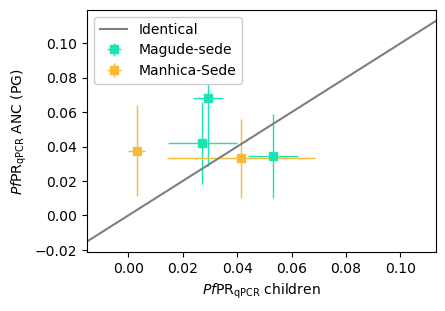

Cross vs MiPMon ANC (MG):
Linear parameter fitting: origin = 0.016253132900767672, slope = 0.5175222823771196
Pearson CC:  0.783659335452509



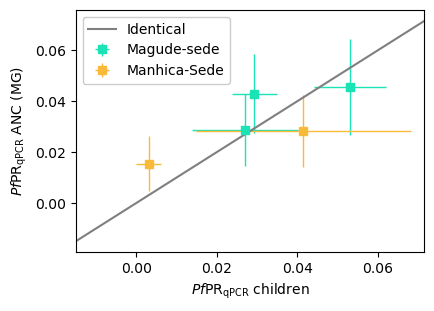

Cross vs MiPMon ANC (HIV+):
Linear parameter fitting: origin = 0.004688948790896419, slope = 1.0711516021388787
Pearson CC:  0.8183455289853918



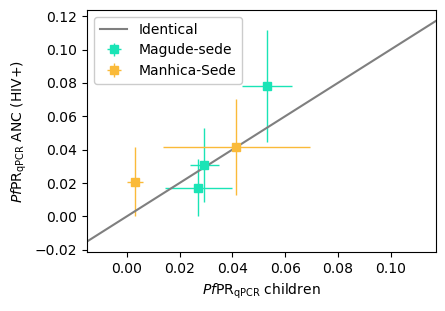

Cross vs MiPMon ANC (HIV-):
Linear parameter fitting: origin = 0.03437497883095465, slope = -0.025074462018725884
Pearson CC:  -0.032556421710540684



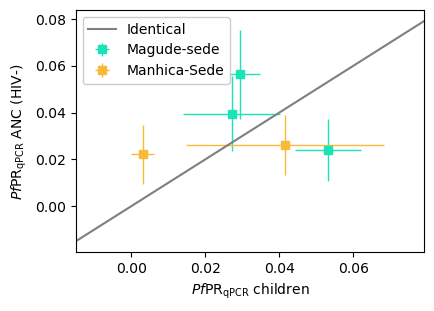

Cross vs MiPMon ANC (PG HIV-):
Linear parameter fitting: origin = 0.04135787758649396, slope = -0.10193355880339706
Pearson CC:  -0.09254468705636543



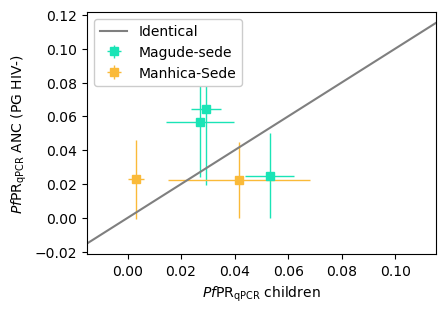

Time taken  17.592799186706543  seconds ( 0 minutes)


In [23]:
#Define test and time binning comparison
cross_test_type = 'pcr'
mip_test_type = 'pcr'
cross_mask = cross_pcr_mask
time_width = 90
time_shift = 0

fit_params = [{},{}]
fit_errs = [{},{}]
slope_95 = {}
slope_68 = {}
origin_95 = {}
origin_68 = {}
pearsonCCs = {}
pearsonCC_errs = {}
pearsonCC_95 = {}
pearsonCC_68 = {}
chi2 = {}

start = time()
for i in mipmon_selection:
    #Plotting scatter
    p, pcorr = notebook_pytools.scatter_linfit_pcc(cross210, mipmon, mipmon_areas, cross_areas, \
                                    cross_test_type, mip_test_type, cross_bins, \
                    time_width = time_width, time_shift = time_shift, print_sizes = False, \
                       cross_mask = cross_mask, mip_mask = mipmon_selection[i], \
                                        title = i, verbose = False, show_fit = False)
    #Calculating statistics
    p_all, fit_err, fit_mean, origin_95[i], origin_68[i], slope_95[i], slope_68[i], \
    pearsonCCs[i], pearsonCC_errs[i], pearsonCC_95[i], pearsonCC_68[i], pcorr_mean, chi2[i] = linfit_pcc(cross210, \
                                                        mipmon, mipmon_areas, cross_areas, \
                                                        cross_test_type, mip_test_type, cross_bins, \
                                            time_width = time_width, time_shift = time_shift, print_sizes = False, \
                                               cross_mask = cross_mask, mip_mask = mipmon_selection[i], \
                                                        title = i, verbose = False, get_chi2 = True)
    fit_params[0][i], fit_params[1][i] = p_all
    fit_errs[0][i], fit_errs[1][i] = fit_err
end = time()
print('Time taken ', end-start,' seconds (', int((end-start)/60), 'minutes)')

In [24]:
pcr_chi2 = pd.DataFrame({'Chi2' : chi2})


In [25]:
pcr_chi2

,Chi2
ANC (HIV+),0.277842
ANC (HIV-),1.538244
ANC (MG),0.408392
ANC (PG HIV-),0.711644
ANC (PG),0.709173
ANC (all),0.963929


Number of Cross samples in bin 0: 1518
Number of Cross samples in bin 1: 1302
Number of Cross samples in bin 2: 302
Number of MiPMon samples in bin around 2017-05-09 01:34:51.699604736: 218
Number of MiPMon samples in bin around 2018-05-31 23:35:40.092165888: 269
Number of MiPMon samples in bin around 2019-05-18 20:39:44.105960192: 282
Number of Cross samples in bin 0: 143
Number of Cross samples in bin 1: 180
Number of Cross samples in bin 2: 142
Number of MiPMon samples in bin around 2017-05-18 21:28:57.062937088: 308
Number of MiPMon samples in bin around 2018-06-05 11:44:00: 383
Number of MiPMon samples in bin around 2019-05-29 14:21:58.309859072: 329
Cross vs MiPMon ANC (all):
Linear parameter fitting: origin = 0.006562565363482435, slope = 0.5566601420909678
Pearson CC:  0.7285884437096876



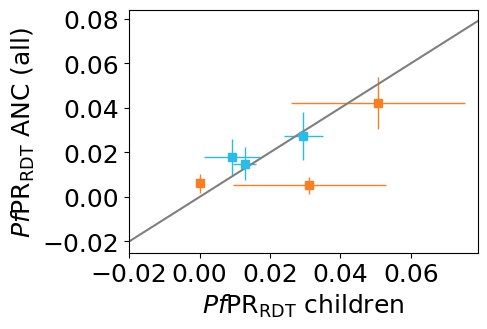

Number of Cross samples in bin 0: 1518
Number of Cross samples in bin 1: 1302
Number of Cross samples in bin 2: 302
Number of MiPMon samples in bin around 2017-05-09 01:34:51.699604736: 45
Number of MiPMon samples in bin around 2018-05-31 23:35:40.092165888: 88
Number of MiPMon samples in bin around 2019-05-18 20:39:44.105960192: 95
Number of Cross samples in bin 0: 143
Number of Cross samples in bin 1: 180
Number of Cross samples in bin 2: 142
Number of MiPMon samples in bin around 2017-05-18 21:28:57.062937088: 82
Number of MiPMon samples in bin around 2018-06-05 11:44:00: 117
Number of MiPMon samples in bin around 2019-05-29 14:21:58.309859072: 103
Cross vs MiPMon ANC (PG):
Linear parameter fitting: origin = 0.015182340015432247, slope = 0.5599299241620843
Pearson CC:  0.6034993308786917



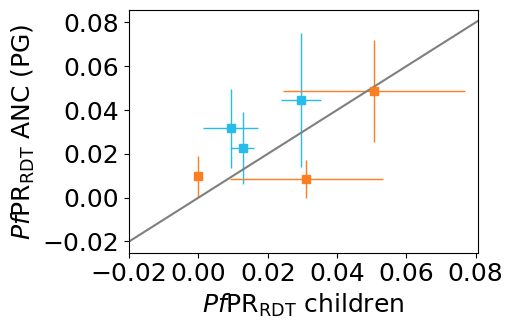

Number of Cross samples in bin 0: 1518
Number of Cross samples in bin 1: 1302
Number of Cross samples in bin 2: 302
Number of MiPMon samples in bin around 2017-05-09 01:34:51.699604736: 173
Number of MiPMon samples in bin around 2018-05-31 23:35:40.092165888: 181
Number of MiPMon samples in bin around 2019-05-18 20:39:44.105960192: 187
Number of Cross samples in bin 0: 143
Number of Cross samples in bin 1: 180
Number of Cross samples in bin 2: 142
Number of MiPMon samples in bin around 2017-05-18 21:28:57.062937088: 226
Number of MiPMon samples in bin around 2018-06-05 11:44:00: 266
Number of MiPMon samples in bin around 2019-05-29 14:21:58.309859072: 226
Cross vs MiPMon ANC (MG):
Linear parameter fitting: origin = 0.0024310678577977767, slope = 0.5868737381963491
Pearson CC:  0.7815525749098697



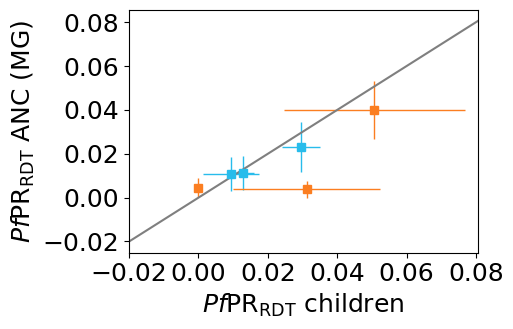

Number of Cross samples in bin 0: 1518
Number of Cross samples in bin 1: 1302
Number of Cross samples in bin 2: 302
Number of MiPMon samples in bin around 2017-05-09 01:34:51.699604736: 68
Number of MiPMon samples in bin around 2018-05-31 23:35:40.092165888: 96
Number of MiPMon samples in bin around 2019-05-18 20:39:44.105960192: 76
Number of Cross samples in bin 0: 143
Number of Cross samples in bin 1: 180
Number of Cross samples in bin 2: 142
Number of MiPMon samples in bin around 2017-05-18 21:28:57.062937088: 103
Number of MiPMon samples in bin around 2018-06-05 11:44:00: 103
Number of MiPMon samples in bin around 2019-05-29 14:21:58.309859072: 95
Cross vs MiPMon ANC (HIV+):
Linear parameter fitting: origin = 0.0049431960685991936, slope = 0.32359849673599084
Pearson CC:  0.5155966701323902



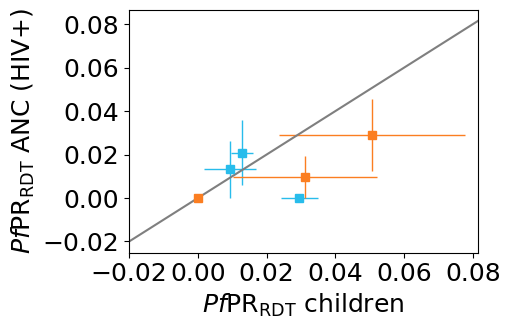

/home/isglobal.lan/apujol/anaconda3/envs/py38/lib/python3.8/site-packages/scipy/stats/_stats_py.py:4424: ConstantInputWarning: An input array is constant; the correlation coefficient is not defined.
  warnings.warn(stats.ConstantInputWarning(msg))


Number of Cross samples in bin 0: 1518
Number of Cross samples in bin 1: 1302
Number of Cross samples in bin 2: 302
Number of MiPMon samples in bin around 2017-05-09 01:34:51.699604736: 150
Number of MiPMon samples in bin around 2018-05-31 23:35:40.092165888: 173
Number of MiPMon samples in bin around 2019-05-18 20:39:44.105960192: 206
Number of Cross samples in bin 0: 143
Number of Cross samples in bin 1: 180
Number of Cross samples in bin 2: 142
Number of MiPMon samples in bin around 2017-05-18 21:28:57.062937088: 205
Number of MiPMon samples in bin around 2018-06-05 11:44:00: 280
Number of MiPMon samples in bin around 2019-05-29 14:21:58.309859072: 234
Cross vs MiPMon ANC (HIV-):
Linear parameter fitting: origin = 0.006744404557301449, slope = 0.6852538345479291
Pearson CC:  0.6878723909905584



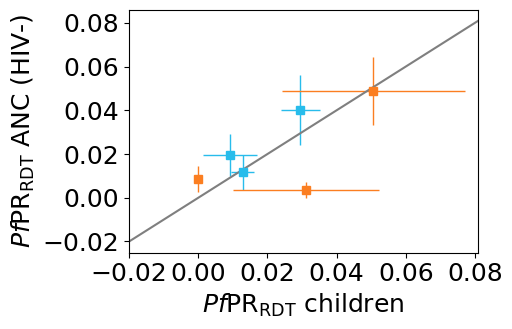

Number of Cross samples in bin 0: 1518
Number of Cross samples in bin 1: 1302
Number of Cross samples in bin 2: 302
Number of MiPMon samples in bin around 2017-05-09 01:34:51.699604736: 32
Number of MiPMon samples in bin around 2018-05-31 23:35:40.092165888: 59
Number of MiPMon samples in bin around 2019-05-18 20:39:44.105960192: 69
Number of Cross samples in bin 0: 143
Number of Cross samples in bin 1: 180
Number of Cross samples in bin 2: 142
Number of MiPMon samples in bin around 2017-05-18 21:28:57.062937088: 53
Number of MiPMon samples in bin around 2018-06-05 11:44:00: 82
Number of MiPMon samples in bin around 2019-05-29 14:21:58.309859072: 77
Cross vs MiPMon ANC (PG HIV-):
Linear parameter fitting: origin = 0.01825740696355415, slope = 0.6220071231586751
Pearson CC:  0.44656287098948866



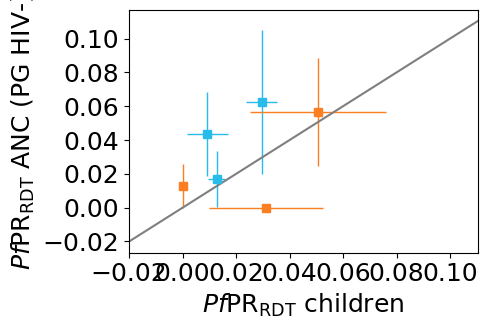

Time taken  19.552392959594727  seconds ( 0 minutes)


In [26]:
#Define test and time binning comparison
cross_test_type = 'rdt'
mip_test_type = 'rdt'
cross_mask = None
time_width = 90

fit_params = [{},{}]
fit_errs = [{},{}]
slope_95 = {}
slope_68 = {}
origin_95 = {}
origin_68 = {}
pearsonCCs = {}
pearsonCC_errs = {}
pearsonCC_95 = {}
pearsonCC_68 = {}
chi2 = {}

start = time()
for i in mipmon_selection:
    #Plotting scatter
    p, pcorr = notebook_pytools.scatter_linfit_pcc(cross210, mipmon, mipmon_areas, cross_areas, \
                                    cross_test_type, mip_test_type, cross_bins, \
                    time_width = time_width, time_shift = time_shift, print_sizes = True, \
                       cross_mask = cross_mask, mip_mask = mipmon_selection[i], \
                                        title = i, verbose = False, show_fit = False, colors = colors[::2], \
                                                  legend = False, fontsize = fontsize)
    #Calculating statistics
    p_all, fit_err, fit_mean, origin_95[i], origin_68[i], slope_95[i], slope_68[i], \
    pearsonCCs[i], pearsonCC_errs[i], pearsonCC_95[i], pearsonCC_68[i], pcorr_mean, chi2[i] = linfit_pcc(cross210, \
                                                        mipmon, mipmon_areas, cross_areas, \
                                                        cross_test_type, mip_test_type, cross_bins, \
                                            time_width = time_width, time_shift = time_shift, print_sizes = False, \
                                               cross_mask = cross_mask, mip_mask = mipmon_selection[i], \
                                                        title = i, verbose = False, get_chi2 = True)
    fit_params[0][i], fit_params[1][i] = p_all
    fit_errs[0][i], fit_errs[1][i] = fit_err
end = time()
print('Time taken ', end-start,' seconds (', int((end-start)/60), 'minutes)')

In [27]:
rdt_chi2 = pd.DataFrame({'Chi2' : chi2})


In [28]:
rdt_chi2

,Chi2
ANC (HIV+),0.417111
ANC (HIV-),0.568937
ANC (MG),0.409989
ANC (PG HIV-),0.608517
ANC (PG),0.555327
ANC (all),0.434689


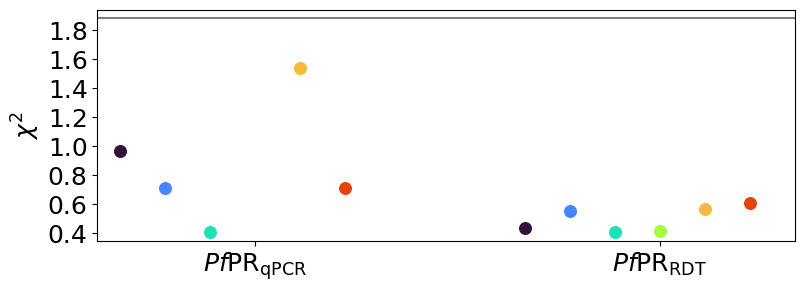

In [29]:
colors_s = [cm.turbo(i/len(mipmon_selection)) for i in range(len(mipmon_selection))]

plt.figure(figsize=[9,3])
for s, selection in enumerate(mipmon_selection):
    x = s
    y = pcr_chi2['Chi2'][selection]
    plt.scatter(x, y, marker = 'o', s = 70, label = selection, color = colors_s[s])
for s, selection in enumerate(mipmon_selection):
    x = 1.5*len(mipmon_selection) + s
    y = rdt_chi2['Chi2'][selection]
    plt.scatter(x, y, marker = 'o', s = 70, label = None, color = colors_s[s])
plt.xticks(ticks = [.5*len(mipmon_selection), 2.*len(mipmon_selection)], \
           labels = [r'$Pf\rm{PR}_{\rm{qPCR}}$', r'$Pf\rm{PR}_{\rm{RDT}}$'], fontsize = fontsize)
plt.yticks(fontsize = fontsize)
#plt.legend(ncol = 2)
plt.ylabel(r'$\chi^2$', fontsize = fontsize)
plt.hlines(1.88, -.5, 2.5*len(mipmon_selection), color = 'tab:grey')
plt.xlim(-.5, 2.5*len(mipmon_selection))
plt.ylim(.35,1.94)
plt.show()